In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.autograd import Variable
from sklearn.svm import SVC

import RNN_neurons
from InputPatterns import match_to_sample_input, repeat_sequence_input
import Solver
# from RNN_neurons import RnnForNeurons
%load_ext autoreload

%autoreload 1
%aimport Solver, RNN_neurons, Solver, InputPatterns

In [ ]:
#Upload the models 
# Initialize the Solver.RunMod with corresponding parameters and 
#load the object_name.load_state_dict(torch.load('saved_dict'))
# Net - network with 200 neurons trained in 100 trials for sample-to-match task
# Net_{G/E/D/C} - netwroks for each pitch for repeat-the-sequence task

#E.g.
# Net.net.load_state_dict(torch.load('Net2000n_dict'))

In [2]:
# Function for plotting eigenvalues of the synaptic matrix
def argand(a,b):
    plt.figure(figsize=(20,20))
    for x in range(len(b)):
        plt.plot([0,b[x].real],[0,b[x].imag],'ko')
    for x in range(len(a)):
        plt.plot([0,a[x].real],[0,a[x].imag],'bo')
    
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.show()

## Check Performance

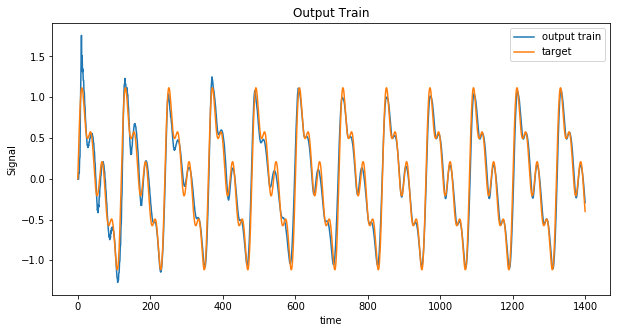

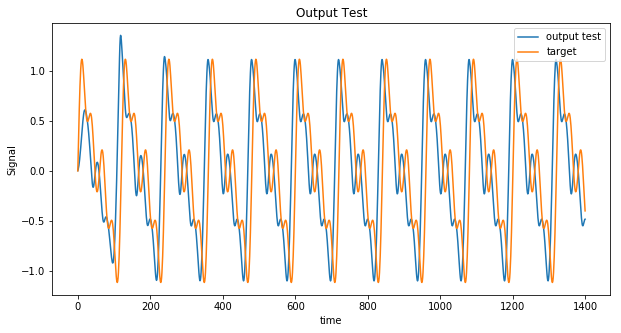

In [10]:
#Parameters

num_neurons=100# number of neurons
output_size=1 # number of output channels 
input_size = 1 # number of input channels 
tau=10 # relaxation constant 
g=1.5 # synapses scaling parameter
alpha=1 # learning rate
delta_t = 2 # interval of time between modifications
simtime=1400 # simulation time

# Construct the target signal 
amp = 1.3;
freq = 1/60;
sin1 =  [np.sin(1.0*np.pi*freq* t) for t in range(simtime)]
sin2 = (amp/2) * np.array([np.sin(2.0*np.pi*freq* t) for t in range(simtime)])
sin3 = (amp/6) * np.array([np.sin(3.0*np.pi*freq* t) for t in range(simtime)])
sin4 = (amp/3) * np.array([np.sin(4.0*np.pi*freq* t) for t in range(simtime)])

target = sin1 + sin2 + sin3 + sin4

target = np.array(target/1.5)
# target = target.float()

length_input=target.shape[0]
signal = np.zeros((1,simtime))

#create and initialize the network
Net_check = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net_check.state_dict()['gen_layer.synapses']) #get the eigenvalues of the net prior to training

#train
output, potentials_record = Solver.run(Net_check, signal, return_measures=True, train=True, delta_t=delta_t, alpha=alpha, lengthSignal=simtime, target=target, check_error_update=False)

#test
output_test = Solver.run(Net_check, signal,lengthSignal=simtime)

# plot output

plt.figure(figsize=(10,5))
plt.title('Output Train')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(output.cpu().detach().numpy(), label = 'output train')
plt.plot(target, label = 'target')
plt.legend()

plt.figure(figsize=(10,5))
plt.title('Output Test')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(output_test.cpu().detach().numpy(), label = 'output test')
plt.plot(target, label ='target')
plt.legend()

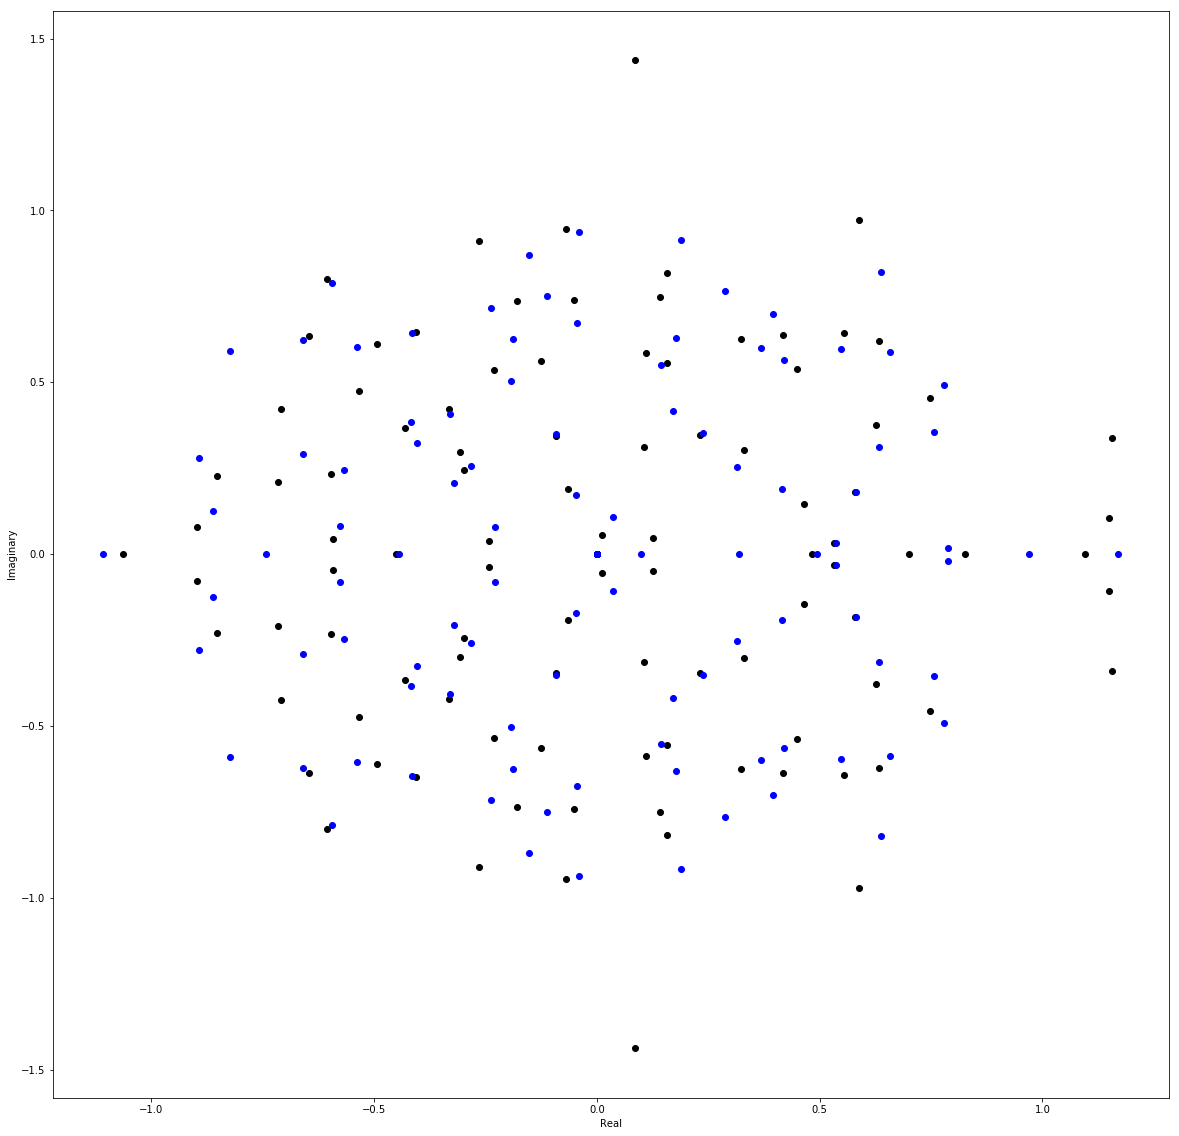

In [13]:
# Plot eigenvalues

eig_after = np.linalg.eigvals(Net_check.state_dict()['gen_layer.synapses'].detach().cpu().numpy())
argand(eig_before,eig_after)

## Task #1: match-to-sample


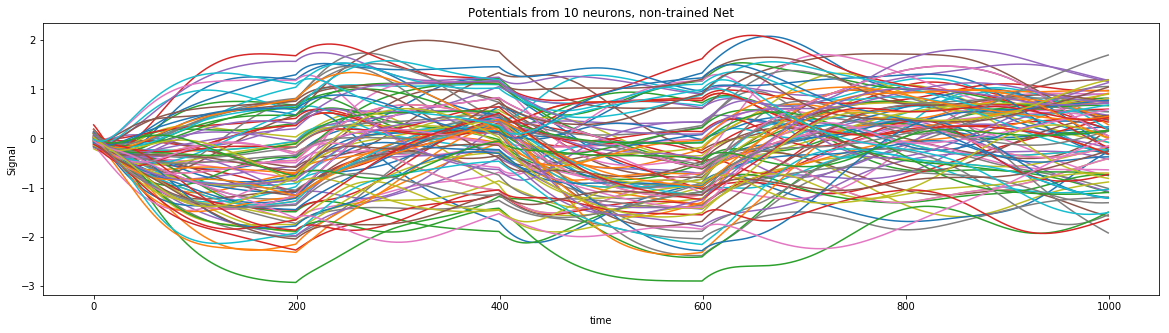

In [14]:
#Check how the not trained Net reacts to the same input: transition from chaotic to non-chaotic activity

#Parameters
num_neurons=1000
input_size=2
output_size=1
tau=30
g=1.5
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=1
delta_t = 2

# signal:
signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

Net_nontrained = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)

output, potentials_record = Solver.run(Net_nontrained, signal, return_measures=True)

# Plot potentials of 10 neurons
plt.figure(figsize=(20,5))
plt.title('Potentials from 10 neurons, non-trained Net')
plt.xlabel('time')
plt.ylabel('Signal')
neurons =  np.random.choice(num_neurons, 100)
for neuron in neurons:
  plt.plot(potentials_record[neuron,:].numpy(), label='neuron'+str(neuron))

target: [-1.]


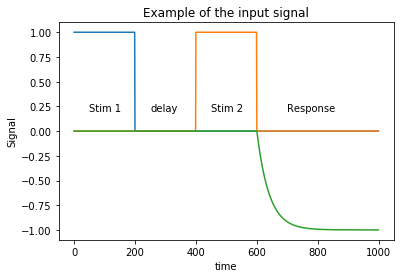

In [30]:
#Visualize input and target example
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=1

# generate input signal and target signal
signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

plt.plot(signal[0,:lengthSignal])
plt.plot(signal[1,:lengthSignal])
plt.plot(target[:lengthSignal])
plt.title('Example of the input signal')
plt.xlabel('time')
plt.ylabel('Signal')

plt.text(lengthStimulus + delay/4, 0.2, 'delay')
plt.text(lengthStimulus/4, 0.2, 'Stim 1')
plt.text(lengthStimulus * 5/4 + delay, 0.2, 'Stim 2')
plt.text(lengthStimulus * 10/4  + delay , 0.2, 'Response')


print('target:', trial_target)

In [ ]:
#TRAIN for sample-to-match task

#Parameters for Network
num_neurons=2000 #number of neurons
input_size=2 #number of input channels
output_size=1 #number of output channels 
tau=30 #relaxation constant 
g=1.5 #synapses scaling parameter
alpha = 10 #learning rate
delta_t = 2 #interval of time between modifications

#Parameters for signal
lengthStimulus = 200
delay = 200
lengthSignal = 1000 


# initialize the net 
Net = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net.state_dict()['gen_layer.synapses']) #get the eigenvalues of the net prior to training

acc_train = np.zeros(10)
acc_test = np.zeros(10)

for epoch in range(10): #each epoch trains the Net of 100 trials and checks it on other 100 trials
  num_trials = 100
  num_trial_test = 100
  # signal for train:
  signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

  # signal for tests:
  signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)

  #train
  output = Solver.run(Net, signal, return_measures=False, train=True, delta_t=delta_t, alpha=alpha, target=target, check_error_update=False)
  
  print('Trial:', (epoch+1)*100)
  #Train error: take the mean of output for the response time and check the sign
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trials)
  for trial in range(num_trials):
    error[trial] = np.sign(np.mean(output[(trial*lengthSignal)+response:lengthSignal*(trial+1)].detach().cpu().numpy())) == trial_target[trial]
  accuracy = np.mean(error)
  acc_train[epoch] = accuracy
  print('Train accuracy:', accuracy)
  
  #test
  output_test = Solver.run(Net, signal_test)

  #Trial error: take the mean of output for the response time and check the sign
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trial_test)
  for trial in range(num_trial_test):
    error[trial] = np.sign(np.mean(output_test[(trial*lengthSignal)+response:lengthSignal*(trial+1)].detach().cpu().numpy())) == trial_target[trial]
  accuracy = np.mean(error)
  acc_test[epoch] = accuracy
  print('Test accuracy:', accuracy)

 

# Training Net with 2000n Results:
# Trial: 100
# Train accuracy: 0.44
# Test accuracy: 0.87
# Trial: 200
# Train accuracy: 0.49
# Test accuracy: 0.96

#torch.save(Net, 'Net_match_to_sample')

In [ ]:
# load the pretrained network
Net=torch.load('Net_match_to_sample')

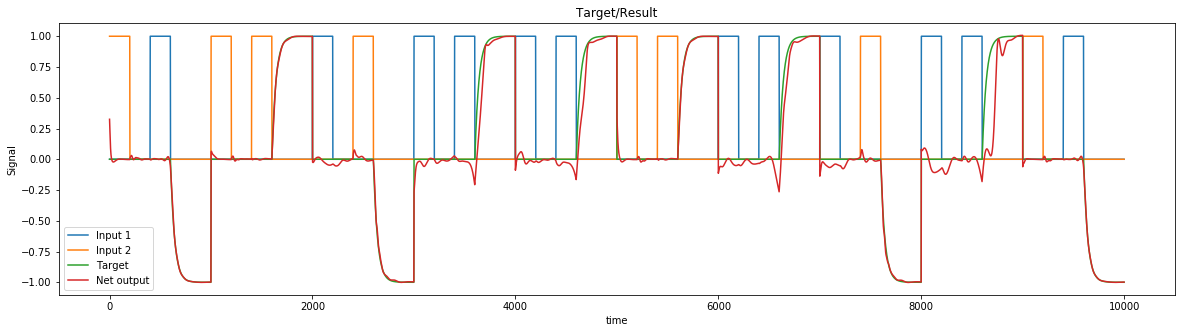

In [91]:
#TEST the trained Net on sample-to-match task

# #Parameters for Network
# num_neurons=2000 #number of neurons
# input_size=2 #number of input channels
# output_size=1 #number of output channels 
# tau=30 #relaxation constant 
# g=1 #synapses scaling parameter
# alpha = 10 #learning rate
# delta_t = 2 #interval of time between modifications
# Net = Solver.run(Net, num_neurons, input_size, output_size, tau, g)
# Net.net.load_state_dict(torch.load('Net2000n_dict'))

lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trial_test = 10



# # signal for tests:
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)

output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)

#Plot the output 
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()

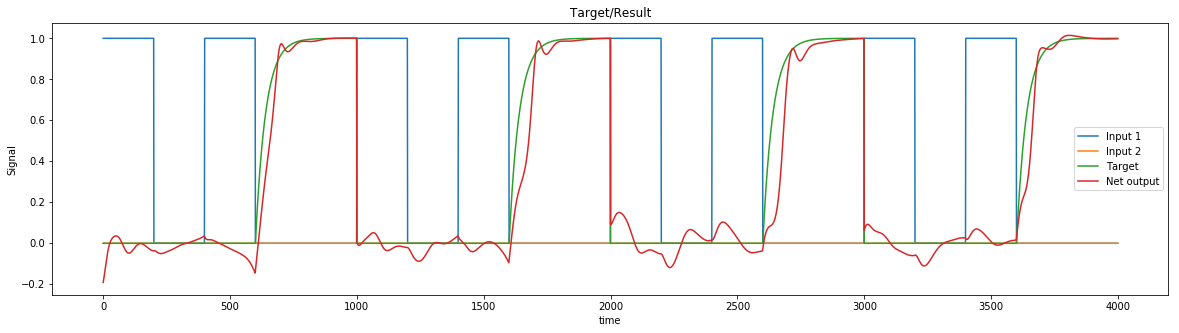

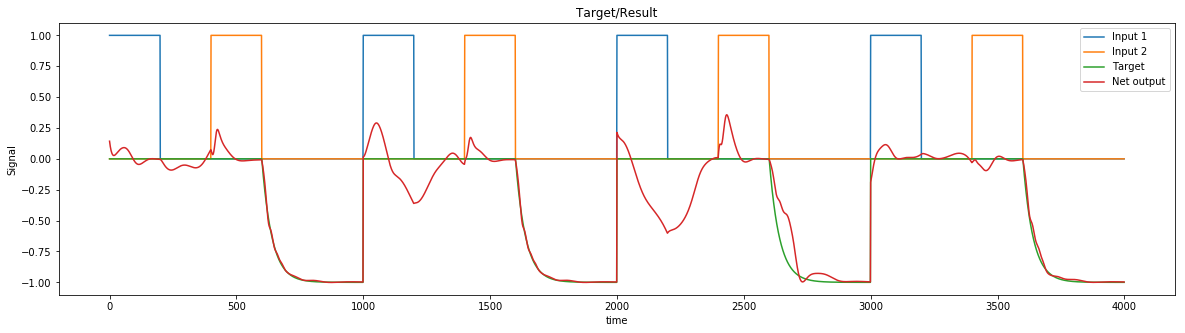

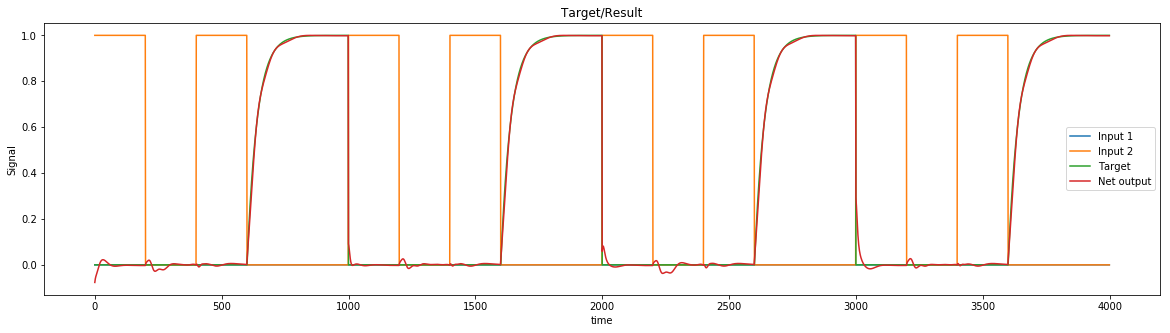

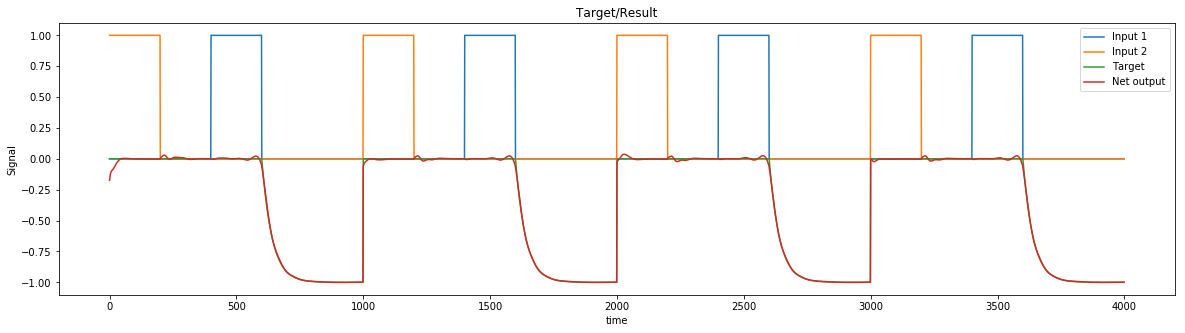

In [150]:
#Get traces of patterns for analysis:
num_trial_test=4
lengthStimulus = 200
delay = 200
lengthSignal = 1000

#pattern AA
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='AA')
output_test, pattern1 = Solver.run(Net, signal_test, return_measures=True)
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()
#pattern AB
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='AB')
output_test, pattern2 = Solver.run(Net, signal_test, return_measures=True)
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()
#pattern BB
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='BB')
output_test, pattern3 = Solver.run(Net, signal_test, return_measures=True)
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()
#pattern BA
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='BA')
output_test, pattern4 = Solver.run(Net, signal_test, return_measures=True)
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()

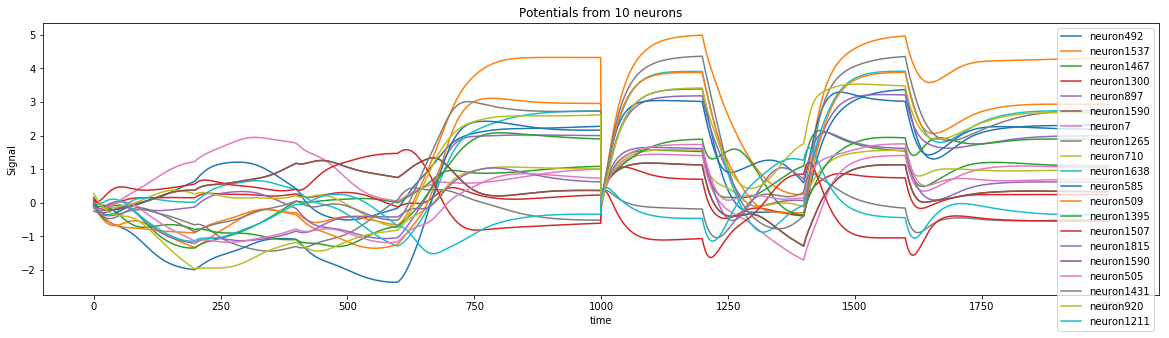

In [44]:
# Plot potentials from 10 neurons in the trained network: transition from chaotic to non-chaotic activity

plt.figure(figsize=(20,5))
plt.title('Potentials from 10 neurons')
plt.xlabel('time')
plt.ylabel('Signal')
neurons =  np.random.choice(num_neurons, 20)

for neuron in neurons:
  plt.plot(potentials_record[neuron,0:5000].numpy(), label='neuron'+str(neuron))
plt.legend()

## Response to different delays

Delay: 50
Accuracy on 20 trials: 0.75
Delay: 100
Accuracy on 20 trials: 0.8
Delay: 200
Accuracy on 20 trials: 0.95
Delay: 300
Accuracy on 20 trials: 1.0
Delay: 400
Accuracy on 20 trials: 0.6


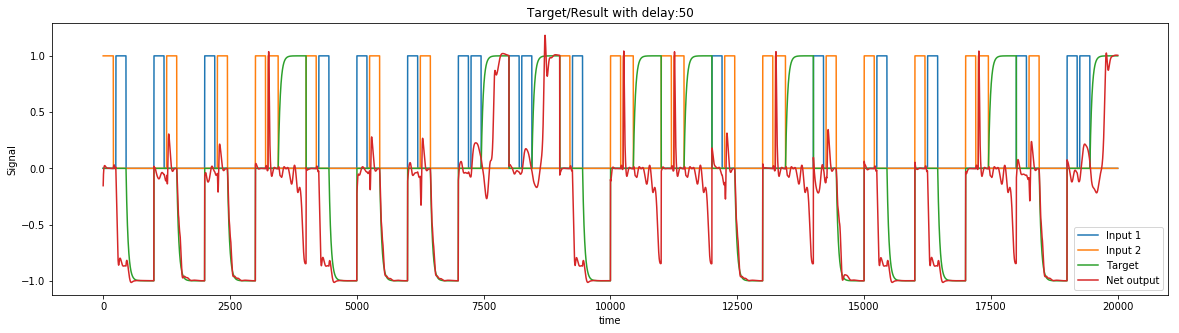

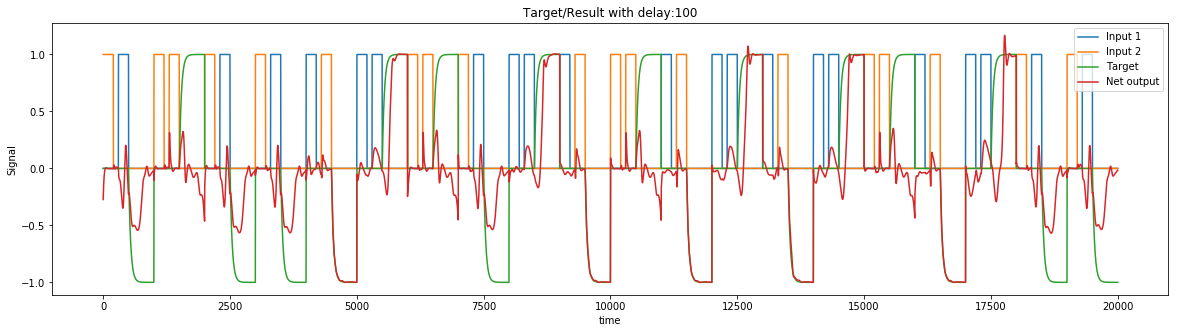

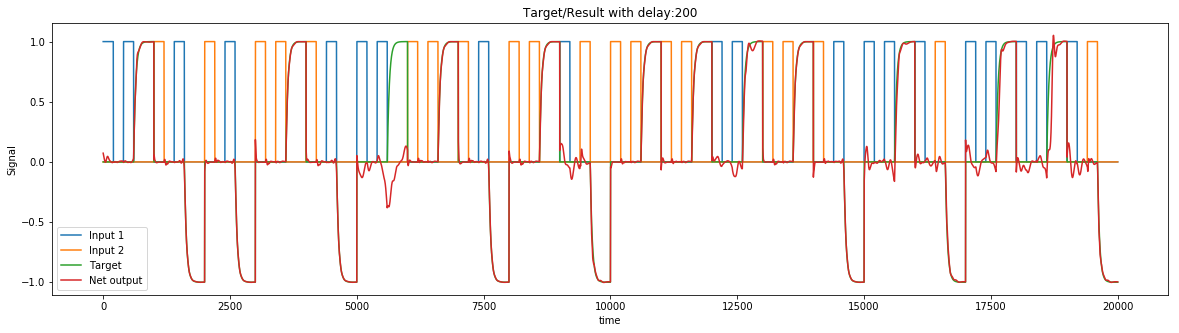

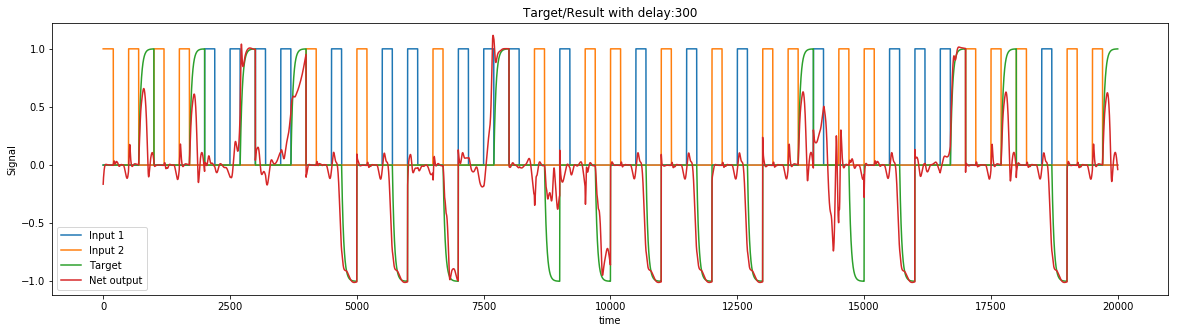

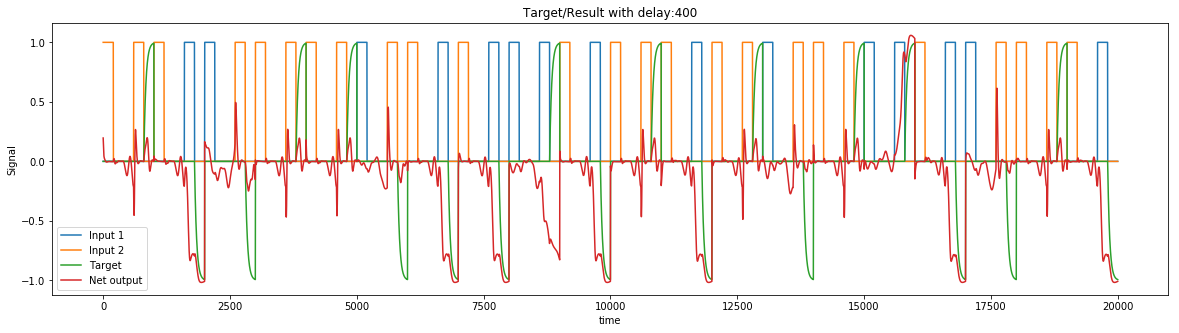

In [48]:
# Chnage the delay (for the Net trained on 200ms delay)

lengthStimulus = 200

lengthSignal = 1000
num_trial_test = 20

acc_delay = np.array([])

for delay in [50,100,200,300,400]: # try delays: 50ms, 100ms, 200ms, 300ms, 400ms
  
  # signal for tests:
  signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)
  
  #test
  output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)
  
  #Accuracy
  #Trial error: take the mean of output for the response time and check the sign
  print('Delay:', delay)
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trial_test)
  for trial in range(num_trial_test):
    error[trial] = np.sign(sum(output_test[(trial*lengthSignal)+response:lengthSignal*(trial+1)].detach().cpu().numpy())/response) == trial_target[trial]
  accuracy = sum(error)/num_trial_test
  acc_delay = np.append(acc_delay, accuracy)
  print('Accuracy on 20 trials:', accuracy)
  
  #Plot the input and Net output for each delay
  
  plt.figure(figsize=(20,5))
  plt.title('Target/Result with delay:' + str(delay))
  plt.xlabel('time')
  plt.ylabel('Signal')
  plt.plot(signal_test[0,:], label='Input 1')
  plt.plot(signal_test[1,:], label='Input 2')
  plt.plot(target_test, label='Target')
  plt.plot(output_test.detach().cpu().numpy(), label = 'Net output')
  plt.legend()


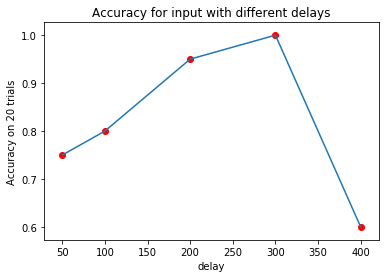

In [49]:
# Plot Net test accuracy vs delay
plt.figure()
plt.title('Accuracy for input with different delays')
plt.xlabel('delay')
plt.ylabel('Accuracy on 20 trials')
plt.plot([50,100,200,300,400], acc_delay)
plt.scatter([50,100,200,300,400], acc_delay,c='r')

# Eigenvalues of synapses matrix

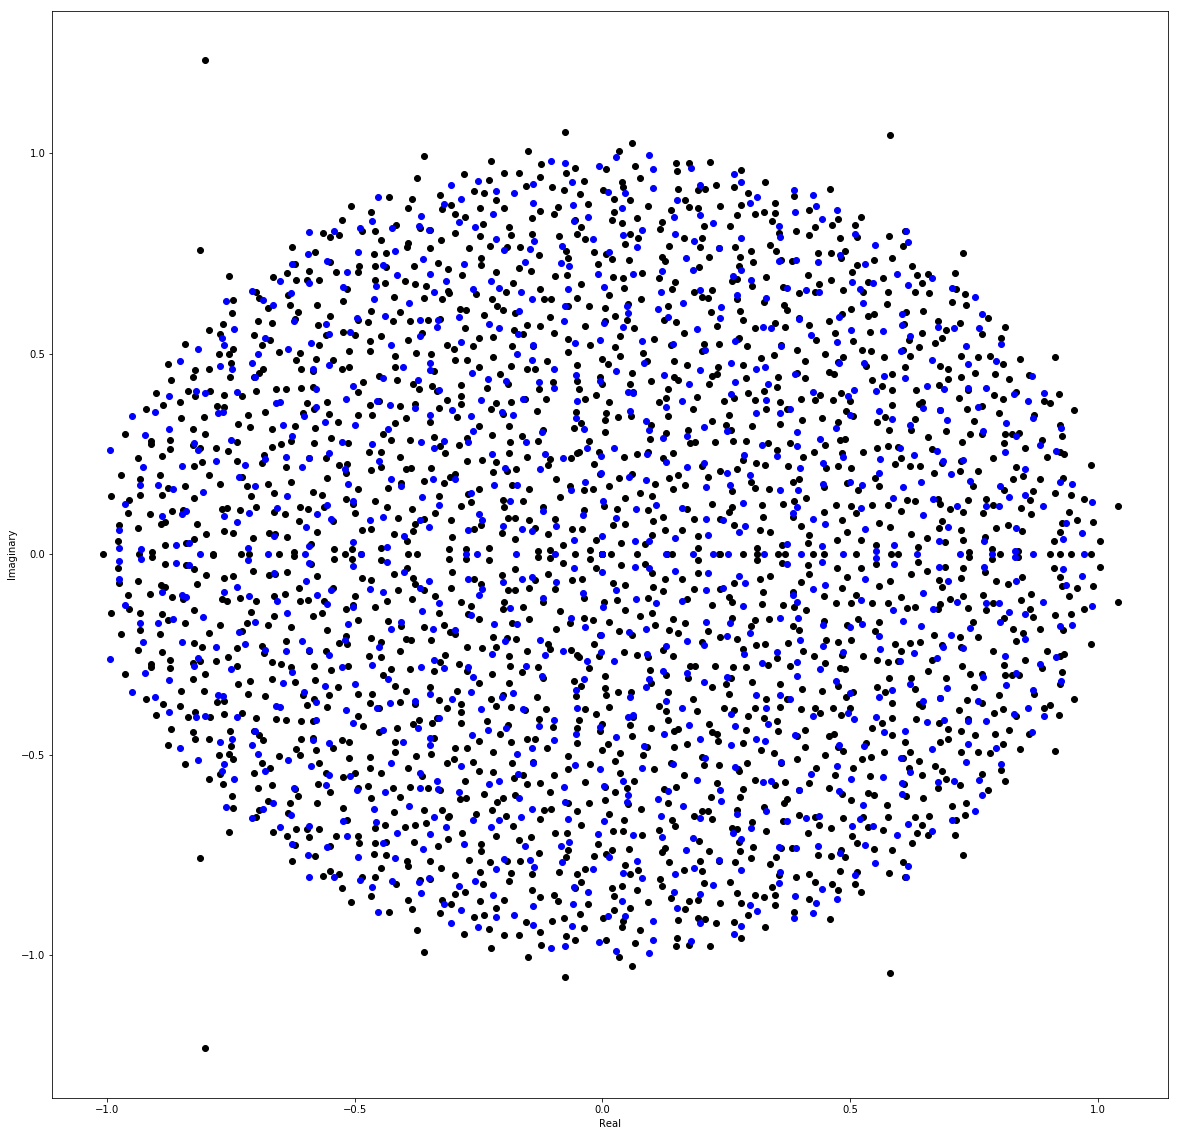

In [53]:
#Plot eigenvalues of synapses matrix
#Parameters
num_neurons=1000
input_size=2
output_size=1
tau=30
g=1
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=20
delta_t = 2

# signal:
Net_nontrained = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net_nontrained.state_dict()['gen_layer.synapses'].detach().cpu().numpy())
eig_after = np.linalg.eigvals(Net.state_dict()['gen_layer.synapses'].detach().cpu().numpy())

argand(eig_before,eig_after)


# State-space analysis

In [116]:
# Find equilibrium points and determine their stability

synapses = Net.state_dict()['gen_layer.synapses'].detach().cpu().numpy()
weights_input = Net.state_dict()['input_map.weight'].detach().cpu().numpy()
#signal_test - full input

# Find where delta_x = 0
delta_x = -potentials_record.numpy() + np.matmul(synapses.T,np.tanh(potentials_record.numpy())) + np.matmul(weights_input.T, signal_test)
delta_x = np.sum(delta_x**2, axis = 0)
equil = np.array(np.where(abs(delta_x)<=0.008))

# Find Jacobian for fix point, find its eigenvalues and determine their sign
for point in equil[0]:
    print(point)
    jacobian = np.zeros((2000,2000))
    diag = np.eye(2000)*-1
    potential = potentials_record.numpy().T[point]
    for i in range(2000):
        jacobian[i] = [synapses.T[i,j]*(1-np.tanh(potential[j])**2) for j in range(2000)]
    jacobian = jacobian + diag
    eigenvalues = np.linalg.eigvals(jacobian)
    
    # Check stability: real part of eigenvalues should be smaller than 0
    for value in eigenvalues:
        if value.real > 0:
            print('Not stable')

In [120]:
delta_x.shape

(10000,)

/home/tanja/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0, 'PC3')

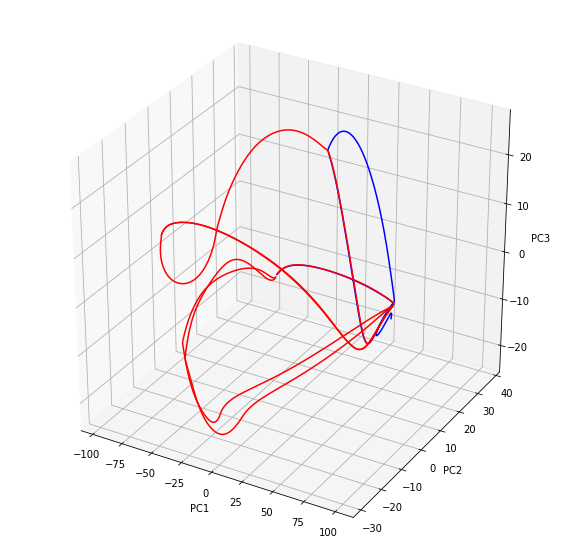

In [89]:
#Plot the state space and put equilibrium points

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA observation - each t, features - neurons' state
pca = PCA(n_components=3)
projected_data1 = pca.fit_transform(potentials_record.numpy().T) #project data to three main components


fig = plt.figure(figsize=(10,10))
plt.title('3D state space')
ax1 = fig.add_subplot(111, projection='3d')


for trial in range(num_trial_test):
  if trial_target[trial] == 1:
    ax1.plot(projected_data1[lengthSignal*trial:lengthSignal*(trial+1),0],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),1],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),2],c='b') 
  else:
    ax1.plot(projected_data1[lengthSignal*trial:lengthSignal*(trial+1),0],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),1],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),2],c='r') 

ax1.scatter(projected_data1[equil[0,0]][0], projected_data1[equil[0,0]][1], projected_data1[equil[0,0]][2], c='g',marker='x', s = 200)      
ax1.scatter(projected_data1[equil[0,1]][0], projected_data1[equil[0,1]][1], projected_data1[equil[0,1]][2], c='g',marker='x', s = 200)      

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


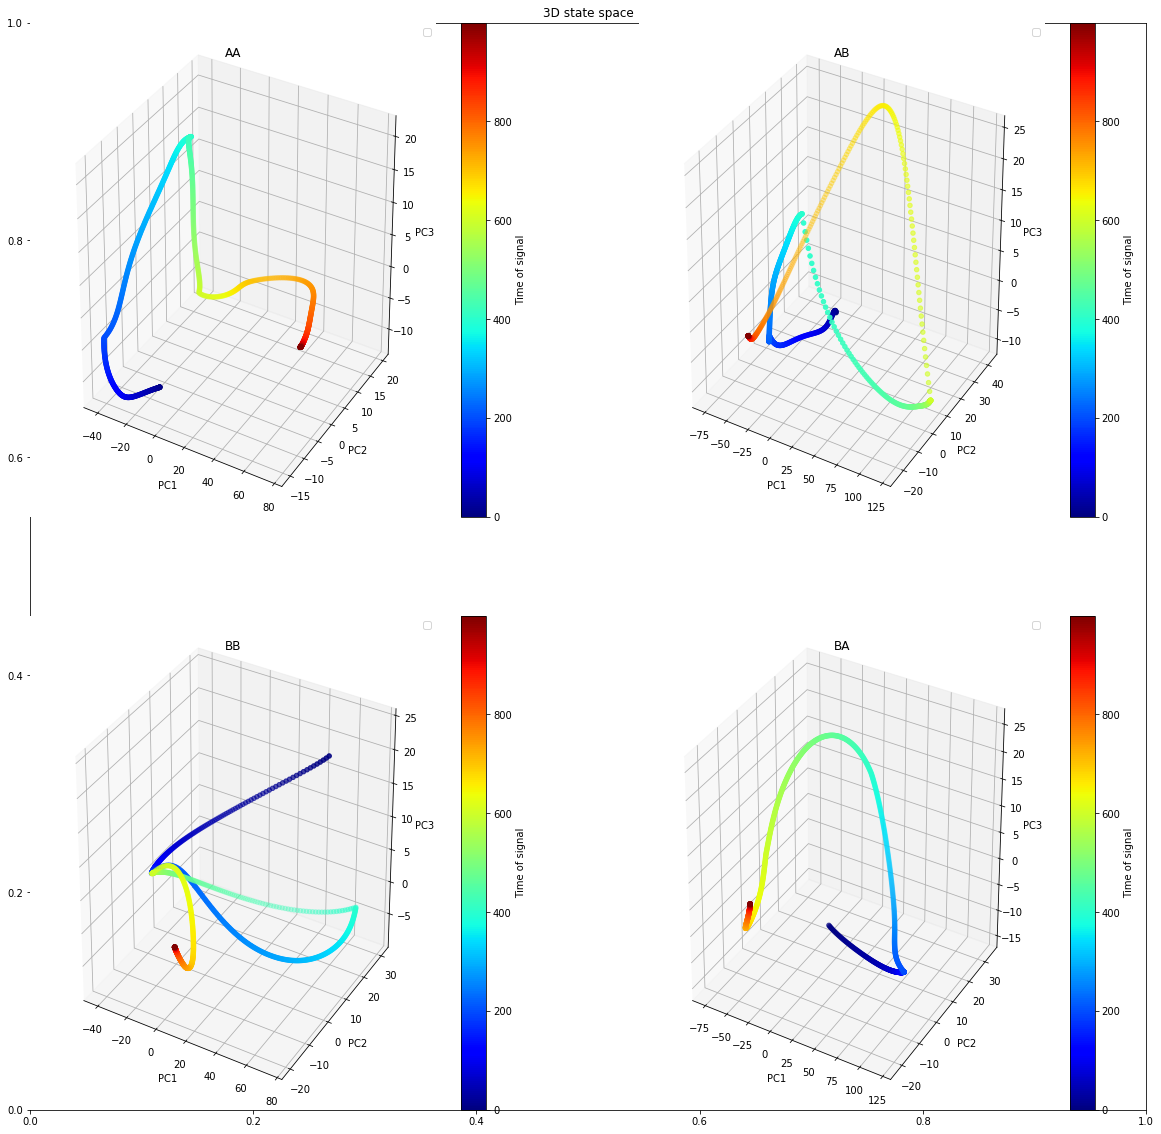

In [122]:
#Plot the state space for different patterns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA observation - each t, features - neurons' state
pca = PCA(n_components=3)
projected_data1 = pca.fit_transform(pattern1.numpy().T)
projected_data2 = pca.fit_transform(pattern2.numpy().T)
projected_data3 = pca.fit_transform(pattern3.numpy().T)
projected_data4 = pca.fit_transform(pattern4.numpy().T)

t_p = [100,500,600] #time points to look at
time = np.arange(0,1000)

fig = plt.figure(figsize=(20,20))
plt.title('3D state space')
ax1 = fig.add_subplot(221, projection='3d')
sc1 = ax1.scatter(projected_data1[:,0],projected_data1[:,1],projected_data1[:,2], c=time, cmap='jet')
ax1.set_title('AA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
fig.colorbar(sc1,label='Time of signal')
ax1.legend()


ax2 = fig.add_subplot(222, projection='3d')
sc2 = ax2.scatter(projected_data2[:,0],projected_data2[:,1],projected_data2[:,2], c=time, cmap='jet')
ax2.set_title('AB')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
fig.colorbar(sc2,label='Time of signal')
ax2.legend()

ax3 = fig.add_subplot(223, projection='3d')
sc3 = ax3.scatter(projected_data3[:,0],projected_data3[:,1],projected_data3[:,2], c=time, cmap='jet')
ax3.set_title('BB')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
fig.colorbar(sc3,label='Time of signal')
ax3.legend()

ax4 = fig.add_subplot(224, projection='3d')
sc4 = ax4.scatter(projected_data4[:,0],projected_data4[:,1],projected_data4[:,2], c=time, cmap='jet')
ax4.set_title('BA')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_zlabel('PC3')
fig.colorbar(sc4,label='Time of signal')
ax4.legend()
    
plt.show()

# Multidimensional Scaling

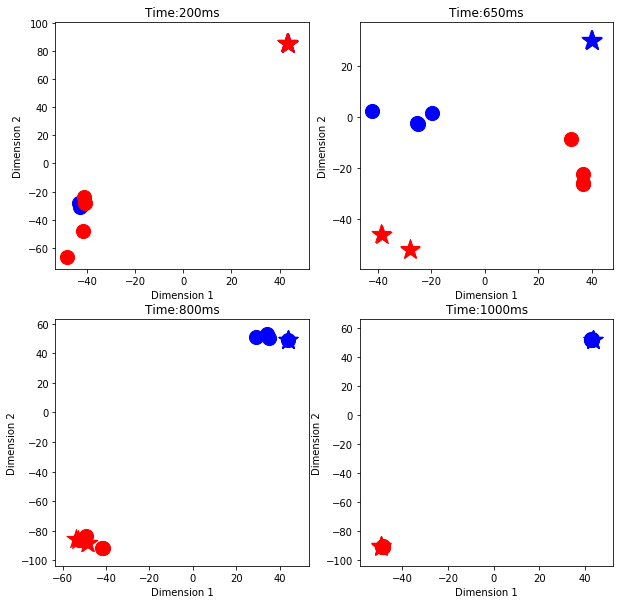

In [152]:
# Multidimensional Scaling

#PCA observation - each t, features - neurons' state
from sklearn.manifold import MDS
embedding = MDS(n_components=2, max_iter=100)

# for this first the Net run 3 trials on each pattern, the resulted potentials records are saved and concatinated 
potentials_record = np.concatenate((pattern1,pattern2,pattern3,pattern4),axis=1)
data_for_mds = potentials_record.astype(np.float64)
projected_data = embedding.fit_transform(data_for_mds.T)

trial_per_pattern=4
time_points = [200, 650, 800, 1000]
fig = plt.figure(figsize=(10,10))
trial_target = ['AA' for _ in range(trial_per_pattern)] + ['AB' for _ in range(trial_per_pattern)] + ['BB' for _ in range(trial_per_pattern)] + ['BA' for _ in range(trial_per_pattern)]

for ind, time_point in enumerate(time_points):
    ax1 = fig.add_subplot(2,2,ind+1)
    for tr in range(16):
        to_plot = projected_data[lengthSignal*tr+time_point-1,:]
        if trial_target[tr]=='AA':
            ax1.scatter(to_plot[0], to_plot[1], c='b', marker='o',s=200, label='AA')
        elif trial_target[tr]=='AB':
            ax1.scatter(to_plot[0], to_plot[1], c='r', marker='o',s=200, label='AB')
        elif trial_target[tr]=='BB':
            ax1.scatter(to_plot[0], to_plot[1], c='b', marker='*',s=400, label='BB')
        elif trial_target[tr]=='BA':
            ax1.scatter(to_plot[0], to_plot[1], c='r', marker='*',s=400, label='BA')
        ax1.set_title('Time:'+str(time_point)+'ms')
        ax1.set_xlabel('Dimension 1')
        ax1.set_ylabel('Dimension 2')
#         ax1.legend()



# Cross temporal classification

In [ ]:
# construct data frame time/observ for training
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trial_test = 1000
num_neurons = 2000

# construct data frame time/observ for training

DataClass = np.zeros([num_trial_test, 2000, 1000])
Target=np.zeros([num_trial_test,1])
  
for repeat in range(num_trial_test):
    
    # signal:
    signal_test, target_test, trial_target = match_to_sample_input(1,lengthStimulus,delay,lengthSignal)
    output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)

    Target[repeat] = trial_target
    DataClass[repeat,:,:] = potentials_record.numpy()

    if repeat%50==0:
        print('Data recorded for ' + str(repeat+1) + ' trials')

# Save recorded data
np.save('Records',DataClass)
np.save('Target',Target)

In [ ]:
# Get recorded data
DataClass = np.load('Records.npy')
Target = np.load('Target.npy')

In [ ]:
# Use linear SVM classifier - train for different data frames:
time_points = [t for t in range(1000)]

classifiers = [SVC(kernel='linear') for k in range(len(time_points))]


n_train = 950
n_test = 1000 - n_train
t=0
for classif in classifiers:
  print('Classifier '+str(t+1)+' training')
  classif.fit(DataClass[:n_train,:,t], Target[:n_train])
  t=t+1

In [ ]:
#make prediction for different time points
acc = np.zeros((len(time_points),len(time_points)))

for t in range(len(time_points)):
    tr=0
    print('Predict for time '+str(t))
    for classif in classifiers:
        acc[tr,t] = np.sum(classif.predict(DataClass[n_train:,:,t])==Target[n_train:].T)/n_test
        tr+=1
        

In [ ]:
# plot decoding time vs training time to look at the encoding property of the network
fig = plt.figure()
plt.title('Cross-temporal classification')
plt.xlabel('Decoding time')
plt.ylabel('Training time')
ax = plt.imshow(acc[::-1,:], cmap='gray')
fig.colorbar(ax, label = 'Accuracy')

#reverse y-axis  (because of imshow settings)

In [ ]:
# For time=850, train LDA and project data on its weights w

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

time_classif = 700

n_train = 900
clLDA = LinearDiscriminantAnalysis(n_components=1)
clLDA.fit(DataClass[:n_train,:,time_classif], Target[:n_train].reshape(-1))
coef_proj = clLDA.coef_

pat1 = np.matmul(coef_proj, pattern1[:,:].numpy())
pat2 = np.matmul(coef_proj, pattern2[:,:].numpy())
pat3 = np.matmul(coef_proj, pattern3[:,:].numpy())
pat4 = np.matmul(coef_proj, pattern4[:,:].numpy())

accuracy = np.sum(clLDA.predict(DataClass[n_train:,:, time_classif])==Target[n_train:].T)/100

time = np.arange(0,1000,1)
plt.figure()
plt.title('Classifier trained at time: ' + str(time_classif) + 'ms, accuracy: ' + str(accuracy))
plt.xlabel('Time')
plt.ylabel('Traces for patterns')
plt.plot(time,pat1.T[time],label='AA') 
plt.plot(time,pat2.T[time],label='AB')
plt.plot(time,pat3.T[time],label='BB')
plt.plot(time,pat4.T[time],label='BA')
plt.axhline(linewidth=1, color='k')
plt.legend()

time = np.arange(700,1000,1)
plt.figure()
plt.title('Activity at response time (enlarged)')
plt.xlabel('Time')
plt.ylabel('Traces for patterns')
plt.plot(time,pat1.T[time],label='AA') 
plt.plot(time,pat2.T[time],label='AB')
plt.plot(time,pat3.T[time],label='BB')
plt.plot(time,pat4.T[time],label='BA')
plt.axhline(linewidth=1, color='k')
plt.axvline(x=800,linewidth=1, color='k')

plt.legend()

plt.figure()
plt.title('LDA coefficients for different neurons')
plt.xlabel('Neurons')
plt.ylabel('Weights (abs)')
plt.bar(np.arange(2000),np.abs(coef_proj).reshape(-1), align='center')

## Task #2: repeat the sequence

Text(0.5, 1.0, 'C')

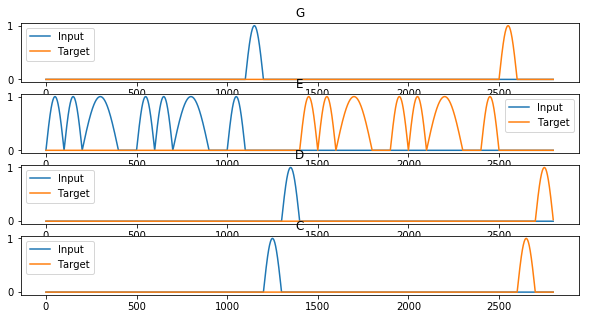

In [154]:
# Visualize the input and target signal for sequence - repeating task
num_trials = 1

signal,target = repeat_sequence_input(num_trials)

fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(411)
ax1.plot(signal[0,:],label='Input')
ax1.plot(target[0,:],label='Target')
ax1.legend()
ax1.set_title('G')

ax2 = fig.add_subplot(412)
ax2.plot(signal[1,:],label='Input')
ax2.plot(target[1,:],label='Target')
ax2.legend()
ax2.set_title('E')

ax3 = fig.add_subplot(413)
ax3.plot(signal[2,:],label='Input')
ax3.plot(target[2,:],label='Target')
ax3.legend()
ax3.set_title('D')

ax4 = fig.add_subplot(414)
ax4.plot(signal[3,:],label='Input')
ax4.plot(target[3,:],label='Target')
ax4.legend()
ax4.set_title('C')

In [214]:
#TRAIN for repeat-the-sequence task

#Parameters (same as before)
num_neurons=800
input_size=1
output_size=1
tau=30
g=1.5
alpha = 10
delta_t = 2

num_trials=50
num_trial_test = 1

# signals
signal, target = repeat_sequence_input(num_trials)
signal_test, target_test = repeat_sequence_input(num_trial_test)


output = np.empty([4,2800*num_trials])
output_test = np.empty([4,2800*num_trial_test])


Nets_notes = {
    'NetG': None,
    'NetE': None,
    'NetD': None,
    'NetC': None
}

Nets_eigenval = {
    'NetG': None,
    'NetE': None,
    'NetD': None,
    'NetC': None
}
fig=plt.figure(figsize=(10,5))
fig_eig=plt.figure(figsize=(10,5))

for note, net in enumerate(list(Nets_notes.keys())):
    print(note, net)
    # initialize the net
    Net_mus = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)

    # keep eigenvalues before training
    Nets_eigenval[net] = np.linalg.eigvals(Net_mus.state_dict()['gen_layer.synapses'].detach().cpu().numpy())

    #train
    output_run = Solver.run(Net_mus, signal[note,:].reshape((1,-1)), return_measures=False, train=True, delta_t=delta_t, alpha=alpha, lengthSignal=2800, target=target[note,:])
    
    output[note,:] = output_run.detach().cpu().numpy()
    
    #test
    output_run, potentials_record = Solver.run(Net_mus, signal_test[note,:].reshape((1,-1)), lengthSignal=2800,return_measures=True)
    output_test[note,:] = output_run.detach().cpu().numpy()

    ax1 = fig.add_subplot(4,1,note+1)
    ax1.plot(target_test[note,:],label='Target')
    ax1.plot(signal_test[note,:],label='Input')
    ax1.plot(output_test[note,:],label='Otput')
    ax1.legend()
    ax1.set_title(net)
    
    ax2 = fig_eig.add_subplot(4,1,note+1)
    for neuron in range(10):
        ax2.plot(potentials_record[neuron,:].numpy())
    ax1.set_title(net)
    
    Nets_notes[net] = Net_mus




0 NetG


KeyboardInterrupt: 

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
#Plot eigenvalues of synapses matrices

for net in list(Nets_notes.keys()):

eig_after_G = np.linalg.eigvals(Net_G.net.state_dict()['gen_layer.synapses'])
eig_after_E = np.linalg.eigvals(Net_E.net.state_dict()['gen_layer.synapses'])
eig_after_D = np.linalg.eigvals(Net_D.net.state_dict()['gen_layer.synapses'])
eig_after_C = np.linalg.eigvals(Net_C.net.state_dict()['gen_layer.synapses'])

argand(eig_before_G,eig_after_G)
argand(eig_before_E,eig_after_E)
argand(eig_before_D,eig_after_D)
argand(eig_before_C,eig_after_C)

In [ ]:
# Saving the net model in google drive as .pt file
torch.save(Net_G,"Net_G.pt")
gsync.update_file_to_folder("Net_G.pt")
torch.save(Net_E,"Net_E.pt")
gsync.update_file_to_folder("Net_E.pt")
torch.save(Net_D,"Net_D.pt")
gsync.update_file_to_folder("Net_D.pt")
torch.save(Net_C,"Net_C.pt")
gsync.update_file_to_folder("Net_C.pt")